# Sweetviz & District Clustering Analysis

This notebook creates a Sweetviz report (associations included) and a district-level clustering analysis (KMeans + PCA), with sample charts suitable for exploration and reporting.

In [1]:
print("Hello")

Hello


In [4]:
# Ensure required packages
import os
os.makedirs('sweetviz_reports', exist_ok=True)

# Monkey patch for Sweetviz compatibility with NumPy 1.21+
import warnings
import numpy as np
if not hasattr(np, 'VisibleDeprecationWarning'):
    np.VisibleDeprecationWarning = DeprecationWarning

try:
    import sweetviz as sv
except Exception:
    import sys
    !{sys.executable} -m pip install sweetviz
    import sweetviz as sv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import IFrame, display

# Load dataset (update path if needed)
df = pd.read_csv('api_data_aadhar_enrolment/merged_final.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# If dataset large, sample for Sweetviz
MAX_SV_ROWS = 50000
if len(df) > MAX_SV_ROWS:
    sv_df = df.sample(n=MAX_SV_ROWS, random_state=42)
    print(f"Using sample of {MAX_SV_ROWS} rows for Sweetviz report")
else:
    sv_df = df.copy()

# Run Sweetviz analysis
print('Running Sweetviz analyze...')
report = sv.analyze(sv_df)
report_path = 'reports/sweetviz_report.html'
report.show_html(report_path, open_browser=False)
print(f'Sweetviz report saved to: {report_path}')

display(IFrame(report_path, width=1000, height=600))

Using sample of 50000 rows for Sweetviz report
Running Sweetviz analyze...


Feature: pincode                             |█████     | [ 50%]   02:39 -> (02:39 left)
Feature: pincode                             |█████     | [ 50%]   00:24 -> (00:24 left)
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report reports/sweetviz_report.html was generated.
Sweetviz report saved to: reports/sweetviz_report.html


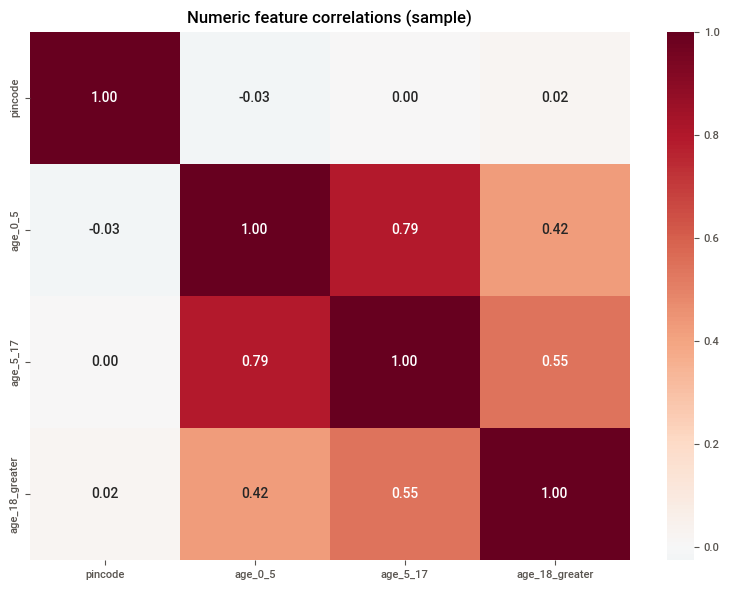

In [5]:
# Associations: correlation heatmap for numeric columns
num_cols = sv_df.select_dtypes(include='number').columns.tolist()
if num_cols:
    corr = sv_df[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
    plt.title('Numeric feature correlations (sample)')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric columns to compute correlations')

k=2, silhouette=0.648
k=3, silhouette=0.581
k=4, silhouette=0.480
k=5, silhouette=0.432
Best k=2 (silhouette=0.648)


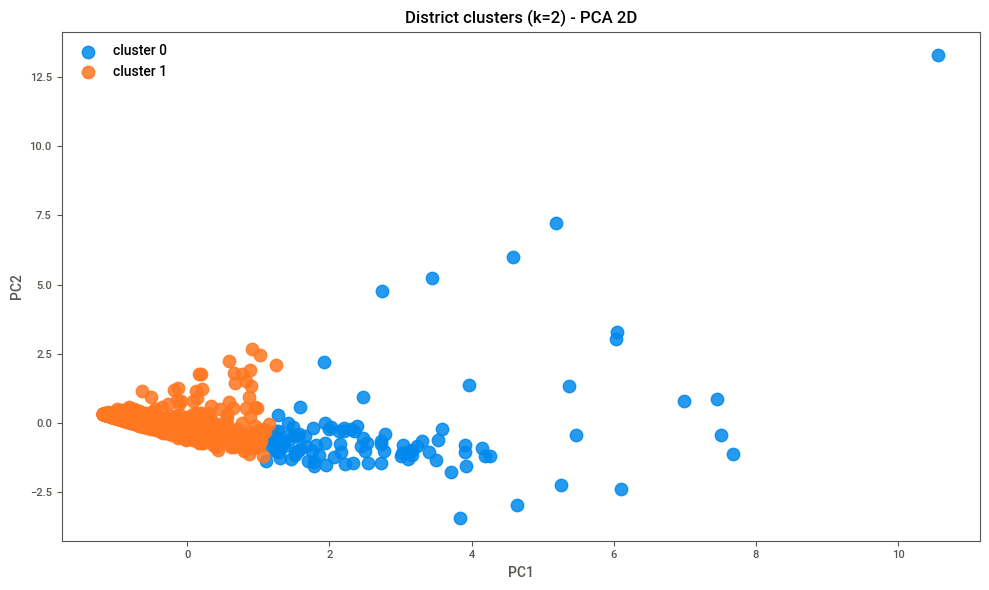


Cluster summary:
         age_0_5  age_5_17  age_18_greater  total_enrollment
cluster                                                     
0        1280774    902120           90707           2273601
1        2182397    788016           75541           3045954


In [6]:
# District-level clustering (aggregate by district)
age_cols = [c for c in ['age_0_5','age_5_17','age_18_greater'] if c in df.columns]
if not age_cols:
    raise RuntimeError('Expected age columns not found')

district_feats = df.groupby('district')[age_cols].sum().fillna(0)

# scale
scaler = StandardScaler()
X = scaler.fit_transform(district_feats.values)

# choose k by silhouette for k in 2..5
best_k, best_score = None, -1
for k in range(2,6):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    if len(set(labels)) > 1:
        s = silhouette_score(X, labels)
        print(f'k={k}, silhouette={s:.3f}')
        if s > best_score:
            best_score = s; best_k = k; best_labels = labels; best_km = km

print(f'Best k={best_k} (silhouette={best_score:.3f})')
district_feats['cluster'] = best_labels

# PCA projection
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X)

plt.figure(figsize=(10,6))
for c in sorted(district_feats['cluster'].unique()):
    idx = district_feats['cluster'] == c
    plt.scatter(proj[idx,0], proj[idx,1], s=80, alpha=0.85, label=f'cluster {c}')
plt.title(f'District clusters (k={best_k}) - PCA 2D')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(frameon=False)
plt.tight_layout(); plt.show()

# cluster summary
district_feats['total_enrollment'] = district_feats[age_cols].sum(axis=1)
print('\nCluster summary:')
print(district_feats.groupby('cluster')[age_cols+['total_enrollment']].sum())

In [7]:
# Sweetviz comparison between two clusters (if at least 2 clusters exist)
clusters = sorted(district_feats['cluster'].unique())
if len(clusters) >= 2:
    c0 = df[df['district'].isin(district_feats[district_feats['cluster']==clusters[0]].index)]
    c1 = df[df['district'].isin(district_feats[district_feats['cluster']==clusters[1]].index)]
    # sample to keep report size reasonable
    N = min(30000, len(c0), len(c1))
    if N > 0:
        c0s = c0.sample(n=N, random_state=42)
        c1s = c1.sample(n=N, random_state=42)
        cmp_report = sv.compare([c0s, f'cluster_{clusters[0]}'], [c1s, f'cluster_{clusters[1]}'])
        cmp_path = 'reports/sweetviz_cluster_compare.html'
        cmp_report.show_html(cmp_path, open_browser=False)
        print(f'Cluster compare report saved to {cmp_path}')
        display(IFrame(cmp_path, width=1000, height=600))
    else:
        print('Not enough rows to sample for cluster comparison')
else:
    print('Less than 2 clusters found; skipping Sweetviz comparison')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)

Report reports/sweetviz_cluster_compare.html was generated.
Cluster compare report saved to reports/sweetviz_cluster_compare.html


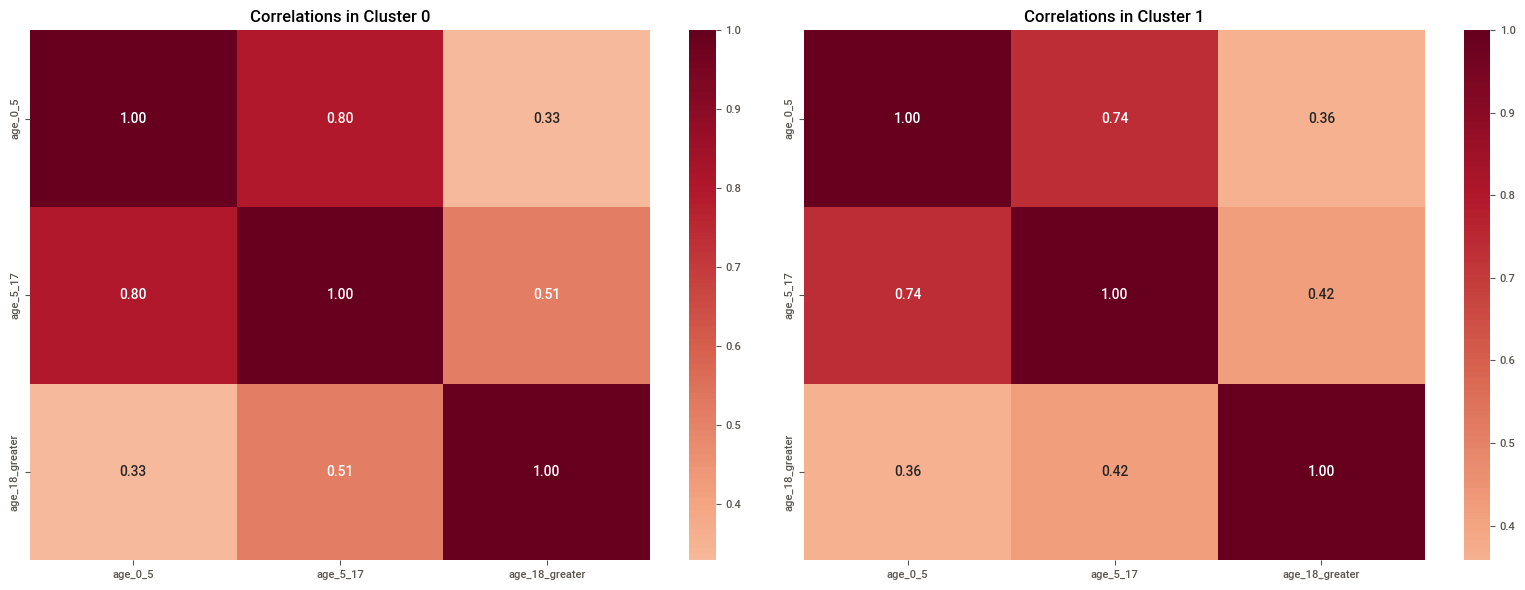

In [8]:
# Associations within clusters: correlation heatmaps for each cluster
num_cols = [c for c in df.select_dtypes(include='number').columns if c in ['age_0_5', 'age_5_17', 'age_18_greater']]
if num_cols and len(clusters) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for i, cl in enumerate(clusters[:2]):  # limit to 2 clusters
        cluster_df = df[df['district'].isin(district_feats[district_feats['cluster'] == cl].index)]
        if len(cluster_df) > 100:  # ensure enough data
            corr = cluster_df[num_cols].corr()
            sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[i])
            axes[i].set_title(f'Correlations in Cluster {cl}')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough data or clusters for intra-cluster associations')

Notes:
- Sweetviz generates an interactive HTML with associations, feature importance, and comparisons.
- Cluster summaries and PCA scatter help interpret clusters; compare clusters with Sweetviz to see demographic differences.
- Adjust sampling thresholds (MAX_SV_ROWS and sample sizes) if your environment has memory limits.